In [1]:
import numpy as np
import pathlib
import struct
import pandas as pd
import gc
import os.path
import tensorflow as tf
import matplotlib.pyplot as plt
import math
from tabulate import tabulate
import csv

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D, Activation, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint

print("Done")

Done


In [2]:
import numpy as np
import pathlib
import struct
import pandas as pd
import gc
import os.path
import tensorflow as tf
import matplotlib.pyplot as plt
import math
from tabulate import tabulate
import csv

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D, Activation, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint

print("Done")

Done


In [3]:
### Usable Files

direction = pathlib.Path("C:/Users/steve/OneDrive/Bureaublad/Studies/Thesis/Data/Detector97/Filtered/Processed/")

# direction = pathlib.Path("C:/Users/steve/OneDrive/Bureaublad/Studies/Thesis/Data/Detector97/Unfiltered/Processed/")

file_list = list(direction.iterdir())

file_num = len(file_list)

num_test_files = 2
eighty = round(0.8*file_num)
twenty = file_num-eighty - num_test_files

list_of_file_ids_train = np.arange(eighty, dtype=int)
print(list_of_file_ids_train)
list_of_file_ids_val = np.arange(eighty,eighty+twenty-num_test_files, dtype=int)

list_of_file_ids_test =np.arange(file_num-num_test_files,file_num)



[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]


In [4]:
##### Functions to process the data

        ### Unnormalization of each signal individually
def Unnormalized(batch_signals):
        
        return batch_signals
        
        ### Normalization of each signal individually
def Normalized(batch_signals):

        for i in range(len(batch_signals)):
            batch_signals[i] = batch_signals[i]/np.max(batch_signals[i])
            
        return batch_signals
            
        
        ### Normalization of the entire value by one common denominator      
def Denominator(batch_signals):  
    
        denominator = 3953.48
        batch_signals = batch_signals/denominator
        
        return batch_signals

In [5]:
# Pre-processing options
Processing = {
    "Unnormalized": Unnormalized,
    "Normalized": Normalized,
    "Denominator": Denominator
}
Process = ["Unnormalized","Normalized","Denominator"]
process = Process[1]
# Loss Function

loss_function = ['mean_absolute_error','mean_squared_error']
lf = 1

# Training Variables
batch_size = 32
num_epochs = 30

steps_per_epoch = eighty*5000 // batch_size

# Learning Rate
initial_lr = 1e-03
final_lr = 1e-06

# initial_lr = 1e-03
# final_lr = 1e-03

def step_decay(epoch):
    lrate = initial_lr * (final_lr/initial_lr)**(epoch/num_epochs)

    print(f'Current Learning rate: {lrate}')
    return lrate





In [6]:
def create_model():
    model = keras.models.Sequential()
    model.add(Conv1D(filters=16, kernel_size=5, activation='relu', input_shape=(1998, 1)))
    model.add(Conv1D(filters=8, kernel_size=5, dilation_rate=2, activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv1D(filters=4, kernel_size=5, dilation_rate=2, activation='relu'))
    model.add(Conv1D(filters=4, kernel_size=5, strides=2, activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv1D(filters=4, kernel_size=3, strides=2))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1))
    return model

In [7]:
model = create_model()

In [8]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import load_model

direction = pathlib.Path("C:/Users/steve/OneDrive/Bureaublad/Studies/Thesis/Data/Detector99/Filtered/")


file_list = list(direction.iterdir())
file_list = file_list[0:20]

file_num = len(file_list)

# Set the path
MC_path = "C:/Users/steve/OneDrive/Bureaublad/Studies/Thesis/Trainings/PDTIN"
process = Process[1]

# Get the number of files in the path
file_models = os.listdir(MC_path)
num_files = len(file_models)

# Initialize lists to store the metrics for each model
mae_per_model = []
mse_per_model = []
mean_per_model = []
std_per_model = []

# Process the data and calculate metrics for each model
for run in range(len(file_models)):
    print(f"Run {run + 1}/{len(file_models)}")
    
    # Load the model weights
    weights_path = os.path.join(MC_path, file_models[run])
    model = create_model()
    model.load_weights(weights_path)
    
    # Initialize lists to store metrics for each file
    mae_per_file = []
    mse_per_file = []
    mean_per_file = []
    std_per_file = []
    
    # Process each file individually
    for file_path in file_list:
        # Read the file
        df_test = pd.read_hdf(file_path, key=None)
        
        # Extract labels and signals
        labels = df_test['PDT']

        signals = df_test[df_test.columns[10:-2]].values
        signals = Processing[process](signals)
        signals = signals[:, :, np.newaxis]

        # Make predictions
        predicted = model.predict(signals)
        predicted = np.squeeze(predicted)
        true = labels

        difference = predicted - true

        # Calculate metrics for the file
        mae = mean_absolute_error(true, predicted)
        mse = mean_squared_error(true, predicted)
        mean = np.mean(predicted - true)
        std = np.std(predicted - true)

        # Append metrics to the file lists
        mae_per_file.append(mae)
        mse_per_file.append(mse)
        mean_per_file.append(mean)
        std_per_file.append(std)
    
    # Calculate metrics for the i-th model
    mae_per_model.append(np.mean(mae_per_file))
    mse_per_model.append(np.mean(mse_per_file))
    mean_per_model.append(np.mean(mean_per_file))
    std_per_model.append(np.mean(std_per_file))

    # Print metrics for the i-th model
    print(f"Metrics for Model {run+1}:")
    print("MAE:", np.mean(mae_per_file))
    print("MSE:", np.mean(mse_per_file))
    print("Mean:", np.mean(mean_per_file))
    print("STD:", np.mean(std_per_file))
    print()

# Calculate metrics for all models combined
combined_mae = np.mean(mae_per_model)
combined_mse = np.mean(mse_per_model)
combined_mean = np.mean(mean_per_model)
combined_std = np.mean(std_per_model)

# Calculate errors for combined metrics
combined_mae_error = np.std(mae_per_model)
combined_mse_error = np.std(mse_per_model)
combined_mean_error = np.std(mean_per_model)
combined_std_error = np.std(std_per_model)

# Print metrics for all models combined
print("Metrics for All Models Combined:")
print(f"Combined MAE: {combined_mae:.3f} ± {combined_mae_error:.3f}")
print(f"Combined MSE: {combined_mse:.3f} ± {combined_mse_error:.3f}")
print(f"Combined Mean: {combined_mean:.3f} ± {combined_mean_error:.3f}")
print(f"Combined STD: {combined_std:.3f} ± {combined_std_error:.3f}")

Run 1/5
Metrics for Model 1:
MAE: 4.5986349341662
MSE: 21.273256182586213
Mean: 4.5986349341662
STD: 0.3547002860217213

Run 2/5
Metrics for Model 2:
MAE: 5.4007314751630595
MSE: 29.28743980070829
Mean: 5.4007314751630595
STD: 0.34574287460314534

Run 3/5
Metrics for Model 3:
MAE: 4.31378561597661
MSE: 18.683606290233843
Mean: 4.31378561597661
STD: 0.2736029801976442

Run 4/5
Metrics for Model 4:
MAE: 4.6893157520479845
MSE: 22.050086230173914
Mean: 4.6893157520479845
STD: 0.24577119994096758

Run 5/5
Metrics for Model 5:
MAE: 4.93475437309954
MSE: 24.572887067979018
Mean: 4.934287513370736
STD: 0.4742584222606937

Metrics for All Models Combined:
Combined MAE: 4.787 ± 0.365
Combined MSE: 23.173 ± 3.588
Combined Mean: 4.787 ± 0.365
Combined STD: 0.339 ± 0.079


In [9]:
file_list = list(direction.iterdir())
file_list = file_list[0:10]

file_num = len(file_list)

Run 1/5
Run 2/5
Run 3/5
Run 4/5
Run 5/5


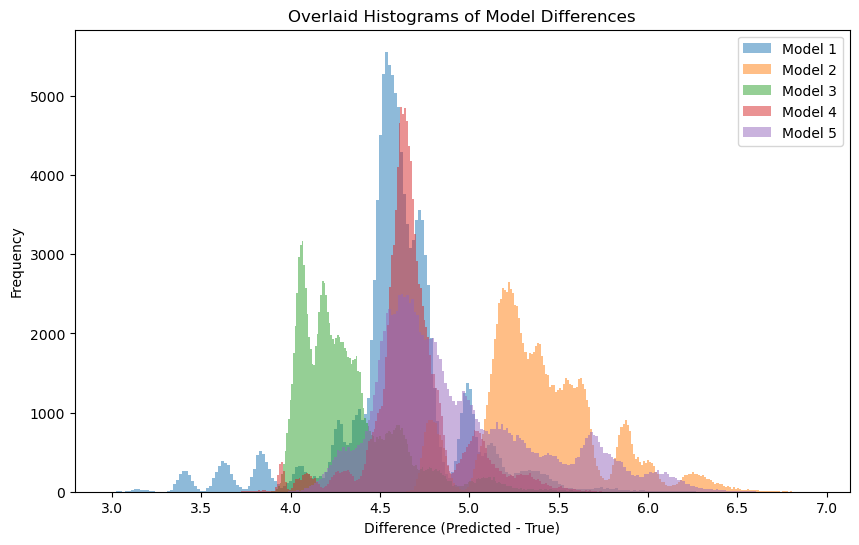

In [10]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import load_model

# Set the path
MC_path = "C:/Users/steve/OneDrive/Bureaublad/Studies/Thesis/Trainings/PDTIN"
process = Process[1]

# Get the number of files in the path
file_models = os.listdir(MC_path)
num_files = len(file_models)

# Create a figure
fig, ax = plt.subplots(figsize=(10, 6))

# Process the data and plot overlaid histograms for each model
for run in range(len(file_models)):
    print(f"Run {run + 1}/{len(file_models)}")
    
    # Load the model weights
    weights_path = os.path.join(MC_path, file_models[run])
    model = create_model()
    model.load_weights(weights_path)
    
    # Initialize lists to store differences for each file
    differences = []
    
    # Process each file individually
    for file_path in file_list:
        # Read the file
        df_test = pd.read_hdf(file_path, key=None)
        
        # Extract labels and signals
        labels = df_test['PDT']

        signals = df_test[df_test.columns[10:-2]].values
        signals = Processing[process](signals)
        signals = signals[:, :, np.newaxis]

        # Make predictions
        predicted = model.predict(signals)
        predicted = np.squeeze(predicted)
        true = labels

        difference = predicted - true
        
        # Append differences to the list
        differences.extend(difference)
    
    # Plot the histogram of differences for the current model
    ax.hist(differences, bins=200, alpha=0.5, label=f'Model {run + 1}')

ax.set_xlabel('Difference (Predicted - True)')
ax.set_ylabel('Frequency')
ax.set_title('Overlaid Histograms of Model Differences')
ax.legend()

plt.show()

In [11]:
ax.set_xlabel('Difference (Predicted - True)')
ax.set_ylabel('Frequency')
ax.set_title('Overlaid Histograms of Model Differences')
ax.legend()

plt.show()